In [27]:
import torch
import random
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#stock network import
import torchvision.models as models

from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader

In [28]:
#Setting GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#define model
model = models.resnet18(weights = None)
num_ftrs = model.fc.in_features

model.fc = nn.Sequential(
    nn.Dropout(0.5),  # Dropout layer
    nn.Linear(num_ftrs, 10)  # Fully connected layer
)

#load trained model
model.load_state_dict(torch.load('/school/intelligence_coursework/Trained_networks/model_state_dict_2.pth'))

#Using GPU
model = model.to(device)
print("Model device:", next(model.parameters()).device)

Model device: cuda:0


In [29]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)), # Random crop back to 32x32
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizing the images
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=4)

classes = trainset.classes
criterion = nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified


In [8]:
checkpoint = torch.load('/school/intelligence_coursework/Trained_networks/model_clpso_checkpoint_20_swarm.pth')
model.load_state_dict(checkpoint['model_state_dict'])
particles = checkpoint['particles']
velocities = checkpoint['velocities']
personal_best_positions = checkpoint['personal_best_positions']
personal_best_scores = checkpoint['personal_best_scores']
global_best_position = checkpoint['global_best_position']
global_best_score = checkpoint['global_best_score']
epoch_losses = checkpoint['epoch_losses']
epoch_precisions = checkpoint['epoch_precisions']
model.train()  # Set the model to training mode


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

#CLPSO
def evaluate(weights):
    with torch.no_grad():
        # Convert numpy arrays to PyTorch tensors
        # Ensure dtype is torch.float32 and tensors are on the correct device
        weights_tensor = torch.tensor(weights, dtype=torch.float32, device=device)
        
        # Split weights into weight and bias for the last layer and reshape
        weight_part = weights_tensor[:-10].view_as(model.fc[1].weight)
        bias_part = weights_tensor[-10:]

        # Check the dtype and convert if necessary
        weight_part = weight_part.to(dtype=torch.float32)
        bias_part = bias_part.to(dtype=torch.float32)

        # Temporarily set the weights of the last layer
        original_weight = model.fc[1].weight.data.clone()
        original_bias = model.fc[1].bias.data.clone()
        
        model.fc[1].weight.data = weight_part
        model.fc[1].bias.data = bias_part

        # Evaluate the model on the validation set
        val_loss = 0.0
        for data in val_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

        # Restore original weights
        model.fc[1].weight.data = original_weight
        model.fc[1].bias.data = original_bias
        return val_loss / len(val_loader.dataset)

In [31]:
#freeze network
for param in model.parameters():
    param.requires_grad = False

    #unfreeze fuly connected layer
for param in model.fc.parameters():
    param.requires_grad = True

#randomize the wights
model.fc[1].reset_parameters()

# Initialize early stopping
early_stopping = EarlyStopping(patience=5)

#validation loss
val_loader = DataLoader(testset, batch_size=256, shuffle=True)

# Define CLPSO parameters
num_particles = 100
num_weights = model.fc[1].weight.data.numel() + model.fc[1].bias.data.numel()
#w = 0.6  # Inertia weight
w_begin = 0.9
w_finish = 0.4
bounds = 0.1
c1, c2 = 1.5, 1.7  # Cognitive and social coefficients

# Initialize particles and velocities
particles = [np.random.uniform(-1, 1, num_weights) for _ in range(num_particles)]
velocities = [np.zeros(num_weights) for _ in range(num_particles)]
personal_best_positions = [np.copy(p) for p in particles]
personal_best_scores = [float('inf') for _ in range(num_particles)]
global_best_position = None
global_best_score = float('inf')

global_best_position = np.random.uniform(-1, 1, num_weights)  # Random initialization
global_best_score = float('inf')
    
# List to store average loss per epoch
epoch_losses = []
epoch_precisions = []

fine_tune_epochs = 150
for epoch in range(fine_tune_epochs):
    print(f"Starting Epoch {epoch + 1}")
    model.train()  # Set the model to training mode
    # Linearly decrease w
    w = w_begin - (epoch / fine_tune_epochs) * (w_begin - w_finish)
    for i in range(num_particles):
        try:
            # Update velocity and apply bounds
            for d in range(num_weights):
                selected_particle = np.random.choice(num_particles)
                best_position_d = personal_best_positions[selected_particle][d]

                velocities[i][d] = w * velocities[i][d] + c1 * np.random.rand() * (personal_best_positions[i][d] - particles[i][d]) + c2 * np.random.rand() * (best_position_d - particles[i][d])
                velocities[i][d] = np.clip(velocities[i][d], -bounds, bounds)

            # Update particle position
            particles[i] += velocities[i]

            fitness = evaluate(particles[i])
            if fitness < personal_best_scores[i]:
                personal_best_scores[i] = fitness
                personal_best_positions[i] = particles[i].copy()

                # Update model weights with the particle's new position
                with torch.no_grad():
                    particle_tensor = torch.from_numpy(particles[i]).float().to(device)
                    weight_part = particle_tensor[:-10].view_as(model.fc[1].weight)
                    bias_part = particle_tensor[-10:]
                    model.fc[1].weight.data.copy_(weight_part)
                    model.fc[1].bias.data.copy_(bias_part)

            if fitness < global_best_score:
                global_best_score = fitness
                global_best_position = particles[i].copy()
                
            print(f"Epoch {epoch + 1}, Particle {i + 1} updated. Fitness: {fitness:0.4f}")
        except Exception as e:
            print(f"Error in Epoch {epoch}, Particle {i}: {e}")
            break
     # Set model weights to global best after updating all particles
    with torch.no_grad():
        # Ensure the global best position is converted to the correct type and device
        global_best_tensor = torch.from_numpy(global_best_position).float().to(device)
        weight_part = global_best_tensor[:-10].view_as(model.fc[1].weight)
        bias_part = global_best_tensor[-10:]
        model.fc[1].weight.data.copy_(weight_part)
        model.fc[1].bias.data.copy_(bias_part)
    
    # Check data types after assignment
    print("Model weight dtype after update:", model.fc[1].weight.data.dtype)
    print("Model bias dtype after update:", model.fc[1].bias.data.dtype)
    
    # Validation loop + precission
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    all_predict = []
    all_labels = []
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predict = torch.max(outputs, 1)
            all_predict.extend(predict.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    epoch_losses.append(val_loss)
    
    # Calculate and store precision
    precision = precision_score(all_labels, all_predict, average='weighted', zero_division=1)
    epoch_precisions.append(precision)

    print(f"Epoch {epoch + 1} completed. Best score so far: {global_best_score:0.4f}. Validation Loss: {val_loss:0.4f}")

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

Starting Epoch 1
Epoch 1, Particle 1 updated. Fitness: 12.6182
Epoch 1, Particle 2 updated. Fitness: 12.3776
Epoch 1, Particle 3 updated. Fitness: 12.6511
Epoch 1, Particle 4 updated. Fitness: 14.3189
Epoch 1, Particle 5 updated. Fitness: 13.6359
Epoch 1, Particle 6 updated. Fitness: 14.8614
Epoch 1, Particle 7 updated. Fitness: 12.0321
Epoch 1, Particle 8 updated. Fitness: 12.7806
Epoch 1, Particle 9 updated. Fitness: 13.7906
Epoch 1, Particle 10 updated. Fitness: 10.5705
Epoch 1, Particle 11 updated. Fitness: 10.7756
Epoch 1, Particle 12 updated. Fitness: 12.3390
Epoch 1, Particle 13 updated. Fitness: 12.0392
Epoch 1, Particle 14 updated. Fitness: 11.9723
Epoch 1, Particle 15 updated. Fitness: 13.9324
Epoch 1, Particle 16 updated. Fitness: 12.4086
Epoch 1, Particle 17 updated. Fitness: 14.1551
Epoch 1, Particle 18 updated. Fitness: 15.1516
Epoch 1, Particle 19 updated. Fitness: 12.0525
Epoch 1, Particle 20 updated. Fitness: 13.0334
Epoch 1, Particle 21 updated. Fitness: 12.4075
Epoch

Epoch 2, Particle 72 updated. Fitness: 12.2154
Epoch 2, Particle 73 updated. Fitness: 11.7400
Epoch 2, Particle 74 updated. Fitness: 9.0346
Epoch 2, Particle 75 updated. Fitness: 12.2417
Epoch 2, Particle 76 updated. Fitness: 14.6638
Epoch 2, Particle 77 updated. Fitness: 10.9701
Epoch 2, Particle 78 updated. Fitness: 10.4612
Epoch 2, Particle 79 updated. Fitness: 11.4130
Epoch 2, Particle 80 updated. Fitness: 10.2946
Epoch 2, Particle 81 updated. Fitness: 14.2628
Epoch 2, Particle 82 updated. Fitness: 10.8326
Epoch 2, Particle 83 updated. Fitness: 13.7813
Epoch 2, Particle 84 updated. Fitness: 11.4740
Epoch 2, Particle 85 updated. Fitness: 12.7788
Epoch 2, Particle 86 updated. Fitness: 10.9569
Epoch 2, Particle 87 updated. Fitness: 11.3618
Epoch 2, Particle 88 updated. Fitness: 12.3344
Epoch 2, Particle 89 updated. Fitness: 9.8275
Epoch 2, Particle 90 updated. Fitness: 11.8175
Epoch 2, Particle 91 updated. Fitness: 10.5228
Epoch 2, Particle 92 updated. Fitness: 13.0659
Epoch 2, Partic

Epoch 4, Particle 41 updated. Fitness: 7.7080
Epoch 4, Particle 42 updated. Fitness: 7.6020
Epoch 4, Particle 43 updated. Fitness: 7.9180
Epoch 4, Particle 44 updated. Fitness: 9.3599
Epoch 4, Particle 45 updated. Fitness: 9.2922
Epoch 4, Particle 46 updated. Fitness: 8.4576
Epoch 4, Particle 47 updated. Fitness: 8.7870
Epoch 4, Particle 48 updated. Fitness: 9.8046
Epoch 4, Particle 49 updated. Fitness: 10.4596
Epoch 4, Particle 50 updated. Fitness: 8.0830
Epoch 4, Particle 51 updated. Fitness: 9.2673
Epoch 4, Particle 52 updated. Fitness: 7.4490
Epoch 4, Particle 53 updated. Fitness: 8.2137
Epoch 4, Particle 54 updated. Fitness: 8.7770
Epoch 4, Particle 55 updated. Fitness: 7.2391
Epoch 4, Particle 56 updated. Fitness: 8.1597
Epoch 4, Particle 57 updated. Fitness: 9.2238
Epoch 4, Particle 58 updated. Fitness: 8.6073
Epoch 4, Particle 59 updated. Fitness: 8.3425
Epoch 4, Particle 60 updated. Fitness: 8.9292
Epoch 4, Particle 61 updated. Fitness: 10.2116
Epoch 4, Particle 62 updated. Fi

Epoch 6, Particle 12 updated. Fitness: 6.2185
Epoch 6, Particle 13 updated. Fitness: 5.8470
Epoch 6, Particle 14 updated. Fitness: 6.1431
Epoch 6, Particle 15 updated. Fitness: 6.9653
Epoch 6, Particle 16 updated. Fitness: 6.1491
Epoch 6, Particle 17 updated. Fitness: 6.5840
Epoch 6, Particle 18 updated. Fitness: 7.5215
Epoch 6, Particle 19 updated. Fitness: 6.1991
Epoch 6, Particle 20 updated. Fitness: 6.0126
Epoch 6, Particle 21 updated. Fitness: 6.5255
Epoch 6, Particle 22 updated. Fitness: 6.0264
Epoch 6, Particle 23 updated. Fitness: 6.4519
Epoch 6, Particle 24 updated. Fitness: 5.5334
Epoch 6, Particle 25 updated. Fitness: 5.4265
Epoch 6, Particle 26 updated. Fitness: 6.3918
Epoch 6, Particle 27 updated. Fitness: 6.9495
Epoch 6, Particle 28 updated. Fitness: 7.1373
Epoch 6, Particle 29 updated. Fitness: 5.8017
Epoch 6, Particle 30 updated. Fitness: 6.1832
Epoch 6, Particle 31 updated. Fitness: 6.6964
Epoch 6, Particle 32 updated. Fitness: 6.9231
Epoch 6, Particle 33 updated. Fitn

Epoch 7, Particle 87 updated. Fitness: 5.0479
Epoch 7, Particle 88 updated. Fitness: 4.6161
Epoch 7, Particle 89 updated. Fitness: 4.3164
Epoch 7, Particle 90 updated. Fitness: 4.6283
Epoch 7, Particle 91 updated. Fitness: 4.0645
Epoch 7, Particle 92 updated. Fitness: 5.6502
Epoch 7, Particle 93 updated. Fitness: 4.9770
Epoch 7, Particle 94 updated. Fitness: 4.9878
Epoch 7, Particle 95 updated. Fitness: 4.8592
Epoch 7, Particle 96 updated. Fitness: 4.1594
Epoch 7, Particle 97 updated. Fitness: 4.9608
Epoch 7, Particle 98 updated. Fitness: 5.6347
Epoch 7, Particle 99 updated. Fitness: 4.7931
Epoch 7, Particle 100 updated. Fitness: 4.7194
Model weight dtype after update: torch.float32
Model bias dtype after update: torch.float32
Epoch 7 completed. Best score so far: 3.9730. Validation Loss: 2.7894
Starting Epoch 8
Epoch 8, Particle 1 updated. Fitness: 4.9983
Epoch 8, Particle 2 updated. Fitness: 4.3354
Epoch 8, Particle 3 updated. Fitness: 4.3400
Epoch 8, Particle 4 updated. Fitness: 5.0

Epoch 9, Particle 58 updated. Fitness: 3.8621
Epoch 9, Particle 59 updated. Fitness: 3.4079
Epoch 9, Particle 60 updated. Fitness: 3.7115
Epoch 9, Particle 61 updated. Fitness: 3.5424
Epoch 9, Particle 62 updated. Fitness: 3.5506
Epoch 9, Particle 63 updated. Fitness: 3.6070
Epoch 9, Particle 64 updated. Fitness: 3.8188
Epoch 9, Particle 65 updated. Fitness: 3.5936
Epoch 9, Particle 66 updated. Fitness: 3.2402
Epoch 9, Particle 67 updated. Fitness: 3.6376
Epoch 9, Particle 68 updated. Fitness: 3.8801
Epoch 9, Particle 69 updated. Fitness: 3.5570
Epoch 9, Particle 70 updated. Fitness: 4.0462
Epoch 9, Particle 71 updated. Fitness: 3.8381
Epoch 9, Particle 72 updated. Fitness: 3.7775
Epoch 9, Particle 73 updated. Fitness: 3.8194
Epoch 9, Particle 74 updated. Fitness: 2.9955
Epoch 9, Particle 75 updated. Fitness: 3.4961
Epoch 9, Particle 76 updated. Fitness: 3.6141
Epoch 9, Particle 77 updated. Fitness: 3.6834
Epoch 9, Particle 78 updated. Fitness: 3.5790
Epoch 9, Particle 79 updated. Fitn

Epoch 11, Particle 26 updated. Fitness: 3.5750
Epoch 11, Particle 27 updated. Fitness: 3.5022
Epoch 11, Particle 28 updated. Fitness: 3.4923
Epoch 11, Particle 29 updated. Fitness: 3.5600
Epoch 11, Particle 30 updated. Fitness: 3.3446
Epoch 11, Particle 31 updated. Fitness: 3.3332
Epoch 11, Particle 32 updated. Fitness: 3.0459
Epoch 11, Particle 33 updated. Fitness: 3.4464
Epoch 11, Particle 34 updated. Fitness: 3.2588
Epoch 11, Particle 35 updated. Fitness: 3.7102
Epoch 11, Particle 36 updated. Fitness: 3.3609
Epoch 11, Particle 37 updated. Fitness: 3.4058
Epoch 11, Particle 38 updated. Fitness: 3.7282
Epoch 11, Particle 39 updated. Fitness: 3.4050
Epoch 11, Particle 40 updated. Fitness: 3.2035
Epoch 11, Particle 41 updated. Fitness: 3.5420
Epoch 11, Particle 42 updated. Fitness: 3.3930
Epoch 11, Particle 43 updated. Fitness: 3.4229
Epoch 11, Particle 44 updated. Fitness: 3.1697
Epoch 11, Particle 45 updated. Fitness: 3.1613
Epoch 11, Particle 46 updated. Fitness: 3.6047
Epoch 11, Par

Epoch 12, Particle 97 updated. Fitness: 3.0079
Epoch 12, Particle 98 updated. Fitness: 2.8270
Epoch 12, Particle 99 updated. Fitness: 3.2113
Epoch 12, Particle 100 updated. Fitness: 3.2036
Model weight dtype after update: torch.float32
Model bias dtype after update: torch.float32
Epoch 12 completed. Best score so far: 2.5496. Validation Loss: 2.0434
Starting Epoch 13
Epoch 13, Particle 1 updated. Fitness: 3.4879
Epoch 13, Particle 2 updated. Fitness: 3.2752
Epoch 13, Particle 3 updated. Fitness: 3.0403
Epoch 13, Particle 4 updated. Fitness: 2.8063
Epoch 13, Particle 5 updated. Fitness: 3.3085
Epoch 13, Particle 6 updated. Fitness: 3.1879
Epoch 13, Particle 7 updated. Fitness: 3.2300
Epoch 13, Particle 8 updated. Fitness: 3.3163
Epoch 13, Particle 9 updated. Fitness: 3.4056
Epoch 13, Particle 10 updated. Fitness: 3.2917
Epoch 13, Particle 11 updated. Fitness: 2.9778
Epoch 13, Particle 12 updated. Fitness: 2.8214
Epoch 13, Particle 13 updated. Fitness: 2.9472
Epoch 13, Particle 14 update

Epoch 14, Particle 64 updated. Fitness: 3.2863
Epoch 14, Particle 65 updated. Fitness: 3.2217
Epoch 14, Particle 66 updated. Fitness: 2.8538
Epoch 14, Particle 67 updated. Fitness: 3.1324
Epoch 14, Particle 68 updated. Fitness: 2.8117
Epoch 14, Particle 69 updated. Fitness: 3.3875
Epoch 14, Particle 70 updated. Fitness: 3.0406
Epoch 14, Particle 71 updated. Fitness: 3.0147
Epoch 14, Particle 72 updated. Fitness: 3.3592
Epoch 14, Particle 73 updated. Fitness: 3.0995
Epoch 14, Particle 74 updated. Fitness: 2.9484
Epoch 14, Particle 75 updated. Fitness: 2.8169
Epoch 14, Particle 76 updated. Fitness: 3.0831
Epoch 14, Particle 77 updated. Fitness: 3.0547
Epoch 14, Particle 78 updated. Fitness: 2.8500
Epoch 14, Particle 79 updated. Fitness: 2.7129
Epoch 14, Particle 80 updated. Fitness: 3.3167
Epoch 14, Particle 81 updated. Fitness: 3.0771
Epoch 14, Particle 82 updated. Fitness: 3.0298
Epoch 14, Particle 83 updated. Fitness: 3.1409
Epoch 14, Particle 84 updated. Fitness: 2.7860
Epoch 14, Par

Epoch 16, Particle 31 updated. Fitness: 2.9092
Epoch 16, Particle 32 updated. Fitness: 2.8957
Epoch 16, Particle 33 updated. Fitness: 2.7390
Epoch 16, Particle 34 updated. Fitness: 2.6249
Epoch 16, Particle 35 updated. Fitness: 2.7792
Epoch 16, Particle 36 updated. Fitness: 2.8388
Epoch 16, Particle 37 updated. Fitness: 2.7203
Epoch 16, Particle 38 updated. Fitness: 3.1747
Epoch 16, Particle 39 updated. Fitness: 2.6979
Epoch 16, Particle 40 updated. Fitness: 2.9866
Epoch 16, Particle 41 updated. Fitness: 2.7906
Epoch 16, Particle 42 updated. Fitness: 2.8353
Epoch 16, Particle 43 updated. Fitness: 2.7645
Epoch 16, Particle 44 updated. Fitness: 3.0174
Epoch 16, Particle 45 updated. Fitness: 2.7809
Epoch 16, Particle 46 updated. Fitness: 2.7067
Epoch 16, Particle 47 updated. Fitness: 2.9617
Epoch 16, Particle 48 updated. Fitness: 2.6686
Epoch 16, Particle 49 updated. Fitness: 2.6781
Epoch 16, Particle 50 updated. Fitness: 2.9545
Epoch 16, Particle 51 updated. Fitness: 2.5298
Epoch 16, Par

Epoch 17 completed. Best score so far: 2.3078. Validation Loss: 1.8966
Starting Epoch 18
Epoch 18, Particle 1 updated. Fitness: 2.9558
Epoch 18, Particle 2 updated. Fitness: 2.3916
Epoch 18, Particle 3 updated. Fitness: 2.6305
Epoch 18, Particle 4 updated. Fitness: 2.5459
Epoch 18, Particle 5 updated. Fitness: 2.7693
Epoch 18, Particle 6 updated. Fitness: 2.9599
Epoch 18, Particle 7 updated. Fitness: 2.6434
Epoch 18, Particle 8 updated. Fitness: 2.7445
Epoch 18, Particle 9 updated. Fitness: 2.5807
Epoch 18, Particle 10 updated. Fitness: 2.5833
Epoch 18, Particle 11 updated. Fitness: 2.9632
Epoch 18, Particle 12 updated. Fitness: 2.8692
Epoch 18, Particle 13 updated. Fitness: 2.7357
Epoch 18, Particle 14 updated. Fitness: 2.4595
Epoch 18, Particle 15 updated. Fitness: 2.6066
Epoch 18, Particle 16 updated. Fitness: 2.6880
Epoch 18, Particle 17 updated. Fitness: 2.3465
Epoch 18, Particle 18 updated. Fitness: 2.5474
Epoch 18, Particle 19 updated. Fitness: 2.8534
Epoch 18, Particle 20 updat

Epoch 19, Particle 70 updated. Fitness: 2.4442
Epoch 19, Particle 71 updated. Fitness: 2.4441
Epoch 19, Particle 72 updated. Fitness: 3.1909
Epoch 19, Particle 73 updated. Fitness: 2.5951
Epoch 19, Particle 74 updated. Fitness: 2.9063
Epoch 19, Particle 75 updated. Fitness: 2.3586
Epoch 19, Particle 76 updated. Fitness: 2.6460
Epoch 19, Particle 77 updated. Fitness: 2.6797
Epoch 19, Particle 78 updated. Fitness: 2.5687
Epoch 19, Particle 79 updated. Fitness: 2.7083
Epoch 19, Particle 80 updated. Fitness: 2.4849
Epoch 19, Particle 81 updated. Fitness: 2.8696
Epoch 19, Particle 82 updated. Fitness: 2.4342
Epoch 19, Particle 83 updated. Fitness: 2.7347
Epoch 19, Particle 84 updated. Fitness: 2.4993
Epoch 19, Particle 85 updated. Fitness: 2.5382
Epoch 19, Particle 86 updated. Fitness: 2.6812
Epoch 19, Particle 87 updated. Fitness: 2.5125
Epoch 19, Particle 88 updated. Fitness: 2.6073
Epoch 19, Particle 89 updated. Fitness: 2.6439
Epoch 19, Particle 90 updated. Fitness: 2.4117
Epoch 19, Par

Epoch 21, Particle 37 updated. Fitness: 2.3514
Epoch 21, Particle 38 updated. Fitness: 2.2967
Epoch 21, Particle 39 updated. Fitness: 2.5472
Epoch 21, Particle 40 updated. Fitness: 2.5670
Epoch 21, Particle 41 updated. Fitness: 2.4451
Epoch 21, Particle 42 updated. Fitness: 2.1755
Epoch 21, Particle 43 updated. Fitness: 2.4507
Epoch 21, Particle 44 updated. Fitness: 2.4626
Epoch 21, Particle 45 updated. Fitness: 2.6932
Epoch 21, Particle 46 updated. Fitness: 2.3886
Epoch 21, Particle 47 updated. Fitness: 2.4155
Epoch 21, Particle 48 updated. Fitness: 2.6095
Epoch 21, Particle 49 updated. Fitness: 2.3527
Epoch 21, Particle 50 updated. Fitness: 2.3989
Epoch 21, Particle 51 updated. Fitness: 2.4673
Epoch 21, Particle 52 updated. Fitness: 2.5561
Epoch 21, Particle 53 updated. Fitness: 2.1957
Epoch 21, Particle 54 updated. Fitness: 2.3485
Epoch 21, Particle 55 updated. Fitness: 2.2805
Epoch 21, Particle 56 updated. Fitness: 2.4650
Epoch 21, Particle 57 updated. Fitness: 2.1244
Epoch 21, Par

Epoch 23, Particle 4 updated. Fitness: 2.4439
Epoch 23, Particle 5 updated. Fitness: 2.1596
Epoch 23, Particle 6 updated. Fitness: 2.2939
Epoch 23, Particle 7 updated. Fitness: 2.2399
Epoch 23, Particle 8 updated. Fitness: 2.3253
Epoch 23, Particle 9 updated. Fitness: 2.1643
Epoch 23, Particle 10 updated. Fitness: 2.4908
Epoch 23, Particle 11 updated. Fitness: 2.1271
Epoch 23, Particle 12 updated. Fitness: 2.2965
Epoch 23, Particle 13 updated. Fitness: 2.6139
Epoch 23, Particle 14 updated. Fitness: 2.4138
Epoch 23, Particle 15 updated. Fitness: 2.1157
Epoch 23, Particle 16 updated. Fitness: 2.2579
Epoch 23, Particle 17 updated. Fitness: 2.2928
Epoch 23, Particle 18 updated. Fitness: 2.2311
Epoch 23, Particle 19 updated. Fitness: 2.6074
Epoch 23, Particle 20 updated. Fitness: 2.3444
Epoch 23, Particle 21 updated. Fitness: 2.3765
Epoch 23, Particle 22 updated. Fitness: 2.3569
Epoch 23, Particle 23 updated. Fitness: 2.2544
Epoch 23, Particle 24 updated. Fitness: 2.5846
Epoch 23, Particle 

Epoch 24, Particle 75 updated. Fitness: 2.2912
Epoch 24, Particle 76 updated. Fitness: 2.2284
Epoch 24, Particle 77 updated. Fitness: 2.1380
Epoch 24, Particle 78 updated. Fitness: 2.3894
Epoch 24, Particle 79 updated. Fitness: 2.1578
Epoch 24, Particle 80 updated. Fitness: 1.8600
Epoch 24, Particle 81 updated. Fitness: 2.0858
Epoch 24, Particle 82 updated. Fitness: 2.3315
Epoch 24, Particle 83 updated. Fitness: 2.2547
Epoch 24, Particle 84 updated. Fitness: 2.3286
Epoch 24, Particle 85 updated. Fitness: 2.1009
Epoch 24, Particle 86 updated. Fitness: 2.2337
Epoch 24, Particle 87 updated. Fitness: 2.2935
Epoch 24, Particle 88 updated. Fitness: 2.2896
Epoch 24, Particle 89 updated. Fitness: 1.9537
Epoch 24, Particle 90 updated. Fitness: 2.2728
Epoch 24, Particle 91 updated. Fitness: 2.0211
Epoch 24, Particle 92 updated. Fitness: 2.3004
Epoch 24, Particle 93 updated. Fitness: 2.2547
Epoch 24, Particle 94 updated. Fitness: 2.2923
Epoch 24, Particle 95 updated. Fitness: 2.3262
Epoch 24, Par

Epoch 26, Particle 42 updated. Fitness: 2.0206
Epoch 26, Particle 43 updated. Fitness: 2.2929
Epoch 26, Particle 44 updated. Fitness: 2.1021
Epoch 26, Particle 45 updated. Fitness: 2.1574
Epoch 26, Particle 46 updated. Fitness: 2.2662
Epoch 26, Particle 47 updated. Fitness: 2.2469
Epoch 26, Particle 48 updated. Fitness: 2.2411
Epoch 26, Particle 49 updated. Fitness: 2.2832
Epoch 26, Particle 50 updated. Fitness: 2.1125
Epoch 26, Particle 51 updated. Fitness: 2.2856
Epoch 26, Particle 52 updated. Fitness: 1.9459
Epoch 26, Particle 53 updated. Fitness: 2.1323
Epoch 26, Particle 54 updated. Fitness: 2.1027
Epoch 26, Particle 55 updated. Fitness: 1.9650
Epoch 26, Particle 56 updated. Fitness: 2.4183
Epoch 26, Particle 57 updated. Fitness: 2.1133
Epoch 26, Particle 58 updated. Fitness: 2.4478
Epoch 26, Particle 59 updated. Fitness: 2.1981
Epoch 26, Particle 60 updated. Fitness: 2.0348
Epoch 26, Particle 61 updated. Fitness: 2.1097
Epoch 26, Particle 62 updated. Fitness: 1.9678
Epoch 26, Par

Epoch 28, Particle 9 updated. Fitness: 2.2247
Epoch 28, Particle 10 updated. Fitness: 2.0768
Epoch 28, Particle 11 updated. Fitness: 1.8679
Epoch 28, Particle 12 updated. Fitness: 2.1219
Epoch 28, Particle 13 updated. Fitness: 2.2704
Epoch 28, Particle 14 updated. Fitness: 2.2397
Epoch 28, Particle 15 updated. Fitness: 2.1548
Epoch 28, Particle 16 updated. Fitness: 2.1151
Epoch 28, Particle 17 updated. Fitness: 2.1607
Epoch 28, Particle 18 updated. Fitness: 1.9181
Epoch 28, Particle 19 updated. Fitness: 2.1220
Epoch 28, Particle 20 updated. Fitness: 2.1626
Epoch 28, Particle 21 updated. Fitness: 2.0166
Epoch 28, Particle 22 updated. Fitness: 1.9299
Epoch 28, Particle 23 updated. Fitness: 1.9122
Epoch 28, Particle 24 updated. Fitness: 1.9481
Epoch 28, Particle 25 updated. Fitness: 2.2691
Epoch 28, Particle 26 updated. Fitness: 2.1144
Epoch 28, Particle 27 updated. Fitness: 2.1931
Epoch 28, Particle 28 updated. Fitness: 2.0432
Epoch 28, Particle 29 updated. Fitness: 2.0443
Epoch 28, Part

Epoch 29, Particle 80 updated. Fitness: 1.9577
Epoch 29, Particle 81 updated. Fitness: 2.1212
Epoch 29, Particle 82 updated. Fitness: 2.0441
Epoch 29, Particle 83 updated. Fitness: 2.3675
Epoch 29, Particle 84 updated. Fitness: 1.9459
Epoch 29, Particle 85 updated. Fitness: 2.2540
Epoch 29, Particle 86 updated. Fitness: 1.9970
Epoch 29, Particle 87 updated. Fitness: 2.1094
Epoch 29, Particle 88 updated. Fitness: 2.0523
Epoch 29, Particle 89 updated. Fitness: 1.8392
Epoch 29, Particle 90 updated. Fitness: 2.2025
Epoch 29, Particle 91 updated. Fitness: 1.9101
Epoch 29, Particle 92 updated. Fitness: 2.0393
Epoch 29, Particle 93 updated. Fitness: 2.2449
Epoch 29, Particle 94 updated. Fitness: 2.0736
Epoch 29, Particle 95 updated. Fitness: 2.1074
Epoch 29, Particle 96 updated. Fitness: 1.8756
Epoch 29, Particle 97 updated. Fitness: 2.3350
Epoch 29, Particle 98 updated. Fitness: 2.1828
Epoch 29, Particle 99 updated. Fitness: 2.0083
Epoch 29, Particle 100 updated. Fitness: 1.9580
Model weight

Epoch 31, Particle 47 updated. Fitness: 2.1306
Epoch 31, Particle 48 updated. Fitness: 1.8596
Epoch 31, Particle 49 updated. Fitness: 1.8351
Epoch 31, Particle 50 updated. Fitness: 2.0432
Epoch 31, Particle 51 updated. Fitness: 2.0060
Epoch 31, Particle 52 updated. Fitness: 1.8905
Epoch 31, Particle 53 updated. Fitness: 1.8352
Epoch 31, Particle 54 updated. Fitness: 2.0122
Epoch 31, Particle 55 updated. Fitness: 1.9812
Epoch 31, Particle 56 updated. Fitness: 1.9604
Epoch 31, Particle 57 updated. Fitness: 1.8224
Epoch 31, Particle 58 updated. Fitness: 1.8166
Epoch 31, Particle 59 updated. Fitness: 1.8741
Epoch 31, Particle 60 updated. Fitness: 1.7721
Epoch 31, Particle 61 updated. Fitness: 1.7137
Epoch 31, Particle 62 updated. Fitness: 2.2280
Epoch 31, Particle 63 updated. Fitness: 1.8333
Epoch 31, Particle 64 updated. Fitness: 2.0349
Epoch 31, Particle 65 updated. Fitness: 2.1458
Epoch 31, Particle 66 updated. Fitness: 1.9410
Epoch 31, Particle 67 updated. Fitness: 1.7247
Epoch 31, Par

Epoch 33, Particle 14 updated. Fitness: 1.8920
Epoch 33, Particle 15 updated. Fitness: 2.0860
Epoch 33, Particle 16 updated. Fitness: 1.8653
Epoch 33, Particle 17 updated. Fitness: 1.7449
Epoch 33, Particle 18 updated. Fitness: 1.7462
Epoch 33, Particle 19 updated. Fitness: 1.9380
Epoch 33, Particle 20 updated. Fitness: 1.9512
Epoch 33, Particle 21 updated. Fitness: 2.0713
Epoch 33, Particle 22 updated. Fitness: 1.7295
Epoch 33, Particle 23 updated. Fitness: 2.0033
Epoch 33, Particle 24 updated. Fitness: 1.7931
Epoch 33, Particle 25 updated. Fitness: 1.7279
Epoch 33, Particle 26 updated. Fitness: 1.8392
Epoch 33, Particle 27 updated. Fitness: 1.8860
Epoch 33, Particle 28 updated. Fitness: 1.9204
Epoch 33, Particle 29 updated. Fitness: 1.6848
Epoch 33, Particle 30 updated. Fitness: 1.8124
Epoch 33, Particle 31 updated. Fitness: 1.9481
Epoch 33, Particle 32 updated. Fitness: 1.7087
Epoch 33, Particle 33 updated. Fitness: 1.8289
Epoch 33, Particle 34 updated. Fitness: 1.9749
Epoch 33, Par

Epoch 34, Particle 85 updated. Fitness: 1.7831
Epoch 34, Particle 86 updated. Fitness: 1.9454
Epoch 34, Particle 87 updated. Fitness: 1.8601
Epoch 34, Particle 88 updated. Fitness: 1.9712
Epoch 34, Particle 89 updated. Fitness: 1.6792
Epoch 34, Particle 90 updated. Fitness: 1.9936
Epoch 34, Particle 91 updated. Fitness: 1.9059
Epoch 34, Particle 92 updated. Fitness: 1.7454
Epoch 34, Particle 93 updated. Fitness: 1.9848
Epoch 34, Particle 94 updated. Fitness: 1.9434
Epoch 34, Particle 95 updated. Fitness: 1.9626
Epoch 34, Particle 96 updated. Fitness: 1.9243
Epoch 34, Particle 97 updated. Fitness: 1.6102
Epoch 34, Particle 98 updated. Fitness: 1.6245
Epoch 34, Particle 99 updated. Fitness: 1.6192
Epoch 34, Particle 100 updated. Fitness: 1.7091
Model weight dtype after update: torch.float32
Model bias dtype after update: torch.float32
Epoch 34 completed. Best score so far: 1.5643. Validation Loss: 1.1942
Starting Epoch 35
Epoch 35, Particle 1 updated. Fitness: 1.7402
Epoch 35, Particle 2

Epoch 36, Particle 52 updated. Fitness: 1.6543
Epoch 36, Particle 53 updated. Fitness: 1.7191
Epoch 36, Particle 54 updated. Fitness: 1.6445
Epoch 36, Particle 55 updated. Fitness: 1.8213
Epoch 36, Particle 56 updated. Fitness: 1.7199
Epoch 36, Particle 57 updated. Fitness: 1.9526
Epoch 36, Particle 58 updated. Fitness: 1.6656
Epoch 36, Particle 59 updated. Fitness: 1.8003
Epoch 36, Particle 60 updated. Fitness: 1.6642
Epoch 36, Particle 61 updated. Fitness: 1.8082
Epoch 36, Particle 62 updated. Fitness: 1.9219
Epoch 36, Particle 63 updated. Fitness: 1.6073
Epoch 36, Particle 64 updated. Fitness: 1.7857
Epoch 36, Particle 65 updated. Fitness: 1.7580
Epoch 36, Particle 66 updated. Fitness: 1.7469
Epoch 36, Particle 67 updated. Fitness: 1.6166
Epoch 36, Particle 68 updated. Fitness: 1.8133
Epoch 36, Particle 69 updated. Fitness: 1.8020
Epoch 36, Particle 70 updated. Fitness: 1.8170
Epoch 36, Particle 71 updated. Fitness: 2.0734
Epoch 36, Particle 72 updated. Fitness: 1.8498
Epoch 36, Par

Epoch 38, Particle 19 updated. Fitness: 1.6899
Epoch 38, Particle 20 updated. Fitness: 1.6656
Epoch 38, Particle 21 updated. Fitness: 1.6635
Epoch 38, Particle 22 updated. Fitness: 1.6346
Epoch 38, Particle 23 updated. Fitness: 1.6575
Epoch 38, Particle 24 updated. Fitness: 1.7202
Epoch 38, Particle 25 updated. Fitness: 1.8420
Epoch 38, Particle 26 updated. Fitness: 1.5183
Epoch 38, Particle 27 updated. Fitness: 1.7014
Epoch 38, Particle 28 updated. Fitness: 1.7627
Epoch 38, Particle 29 updated. Fitness: 1.6063
Epoch 38, Particle 30 updated. Fitness: 1.8903
Epoch 38, Particle 31 updated. Fitness: 1.8537
Epoch 38, Particle 32 updated. Fitness: 1.8274
Epoch 38, Particle 33 updated. Fitness: 1.8006
Epoch 38, Particle 34 updated. Fitness: 1.5517
Epoch 38, Particle 35 updated. Fitness: 1.6712
Epoch 38, Particle 36 updated. Fitness: 1.7974
Epoch 38, Particle 37 updated. Fitness: 1.7230
Epoch 38, Particle 38 updated. Fitness: 1.7547
Epoch 38, Particle 39 updated. Fitness: 1.5772
Epoch 38, Par

Epoch 39, Particle 90 updated. Fitness: 1.5915
Epoch 39, Particle 91 updated. Fitness: 1.5510
Epoch 39, Particle 92 updated. Fitness: 1.7467
Epoch 39, Particle 93 updated. Fitness: 1.6523
Epoch 39, Particle 94 updated. Fitness: 1.5267
Epoch 39, Particle 95 updated. Fitness: 1.7223
Epoch 39, Particle 96 updated. Fitness: 1.6707
Epoch 39, Particle 97 updated. Fitness: 1.7236
Epoch 39, Particle 98 updated. Fitness: 1.6288
Epoch 39, Particle 99 updated. Fitness: 1.7016
Epoch 39, Particle 100 updated. Fitness: 1.6501
Model weight dtype after update: torch.float32
Model bias dtype after update: torch.float32
Epoch 39 completed. Best score so far: 1.4389. Validation Loss: 1.0939
Starting Epoch 40
Epoch 40, Particle 1 updated. Fitness: 1.6545
Epoch 40, Particle 2 updated. Fitness: 1.9070
Epoch 40, Particle 3 updated. Fitness: 1.6764
Epoch 40, Particle 4 updated. Fitness: 1.6696
Epoch 40, Particle 5 updated. Fitness: 1.5250
Epoch 40, Particle 6 updated. Fitness: 1.5700
Epoch 40, Particle 7 upda

Epoch 41, Particle 57 updated. Fitness: 1.5961
Epoch 41, Particle 58 updated. Fitness: 1.5567
Epoch 41, Particle 59 updated. Fitness: 1.5766
Epoch 41, Particle 60 updated. Fitness: 1.4965
Epoch 41, Particle 61 updated. Fitness: 1.5084
Epoch 41, Particle 62 updated. Fitness: 1.5578
Epoch 41, Particle 63 updated. Fitness: 1.6983
Epoch 41, Particle 64 updated. Fitness: 1.6160
Epoch 41, Particle 65 updated. Fitness: 1.6019
Epoch 41, Particle 66 updated. Fitness: 1.5591
Epoch 41, Particle 67 updated. Fitness: 1.6361
Epoch 41, Particle 68 updated. Fitness: 1.5717
Epoch 41, Particle 69 updated. Fitness: 1.5741
Epoch 41, Particle 70 updated. Fitness: 1.4818
Epoch 41, Particle 71 updated. Fitness: 1.6020
Epoch 41, Particle 72 updated. Fitness: 1.5163
Epoch 41, Particle 73 updated. Fitness: 1.6357
Epoch 41, Particle 74 updated. Fitness: 1.6199
Epoch 41, Particle 75 updated. Fitness: 1.6219
Epoch 41, Particle 76 updated. Fitness: 1.8605
Epoch 41, Particle 77 updated. Fitness: 1.6159
Epoch 41, Par

Epoch 43, Particle 24 updated. Fitness: 1.5551
Epoch 43, Particle 25 updated. Fitness: 1.4405
Epoch 43, Particle 26 updated. Fitness: 1.5845
Epoch 43, Particle 27 updated. Fitness: 1.5353
Epoch 43, Particle 28 updated. Fitness: 1.5107
Epoch 43, Particle 29 updated. Fitness: 1.6185
Epoch 43, Particle 30 updated. Fitness: 1.5673
Epoch 43, Particle 31 updated. Fitness: 1.6257
Epoch 43, Particle 32 updated. Fitness: 1.7073
Epoch 43, Particle 33 updated. Fitness: 1.7258
Epoch 43, Particle 34 updated. Fitness: 1.4729
Epoch 43, Particle 35 updated. Fitness: 1.5588
Epoch 43, Particle 36 updated. Fitness: 1.6653
Epoch 43, Particle 37 updated. Fitness: 1.6940
Epoch 43, Particle 38 updated. Fitness: 1.3962
Epoch 43, Particle 39 updated. Fitness: 1.7366
Epoch 43, Particle 40 updated. Fitness: 1.6343
Epoch 43, Particle 41 updated. Fitness: 1.5303
Epoch 43, Particle 42 updated. Fitness: 1.4131
Epoch 43, Particle 43 updated. Fitness: 1.5469
Epoch 43, Particle 44 updated. Fitness: 1.8048
Epoch 43, Par

Epoch 44, Particle 95 updated. Fitness: 1.5621
Epoch 44, Particle 96 updated. Fitness: 1.6436
Epoch 44, Particle 97 updated. Fitness: 1.4952
Epoch 44, Particle 98 updated. Fitness: 1.5690
Epoch 44, Particle 99 updated. Fitness: 1.4240
Epoch 44, Particle 100 updated. Fitness: 1.4791
Model weight dtype after update: torch.float32
Model bias dtype after update: torch.float32
Epoch 44 completed. Best score so far: 1.3123. Validation Loss: 0.9932
Starting Epoch 45
Epoch 45, Particle 1 updated. Fitness: 1.5148
Epoch 45, Particle 2 updated. Fitness: 1.6008
Epoch 45, Particle 3 updated. Fitness: 1.4951
Epoch 45, Particle 4 updated. Fitness: 1.6681
Epoch 45, Particle 5 updated. Fitness: 1.4639
Epoch 45, Particle 6 updated. Fitness: 1.4432
Epoch 45, Particle 7 updated. Fitness: 1.3617
Epoch 45, Particle 8 updated. Fitness: 1.5812
Epoch 45, Particle 9 updated. Fitness: 1.6177
Epoch 45, Particle 10 updated. Fitness: 1.4677
Epoch 45, Particle 11 updated. Fitness: 1.4549
Epoch 45, Particle 12 update

Epoch 46, Particle 62 updated. Fitness: 1.6282
Epoch 46, Particle 63 updated. Fitness: 1.4315
Epoch 46, Particle 64 updated. Fitness: 1.6804
Epoch 46, Particle 65 updated. Fitness: 1.6112
Epoch 46, Particle 66 updated. Fitness: 1.3289
Epoch 46, Particle 67 updated. Fitness: 1.5825
Epoch 46, Particle 68 updated. Fitness: 1.4085
Epoch 46, Particle 69 updated. Fitness: 1.5633
Epoch 46, Particle 70 updated. Fitness: 1.4340
Epoch 46, Particle 71 updated. Fitness: 1.6071
Epoch 46, Particle 72 updated. Fitness: 1.5068
Epoch 46, Particle 73 updated. Fitness: 1.5022
Epoch 46, Particle 74 updated. Fitness: 1.5775
Epoch 46, Particle 75 updated. Fitness: 1.5642
Epoch 46, Particle 76 updated. Fitness: 1.4195
Epoch 46, Particle 77 updated. Fitness: 1.6217
Epoch 46, Particle 78 updated. Fitness: 1.3865
Epoch 46, Particle 79 updated. Fitness: 1.4774
Epoch 46, Particle 80 updated. Fitness: 1.4251
Epoch 46, Particle 81 updated. Fitness: 1.4259
Epoch 46, Particle 82 updated. Fitness: 1.4140
Epoch 46, Par

Epoch 48, Particle 29 updated. Fitness: 1.3254
Epoch 48, Particle 30 updated. Fitness: 1.3564
Epoch 48, Particle 31 updated. Fitness: 1.5548
Epoch 48, Particle 32 updated. Fitness: 1.3735
Epoch 48, Particle 33 updated. Fitness: 1.4355
Epoch 48, Particle 34 updated. Fitness: 1.4035
Epoch 48, Particle 35 updated. Fitness: 1.2741
Epoch 48, Particle 36 updated. Fitness: 1.3712
Epoch 48, Particle 37 updated. Fitness: 1.4792
Epoch 48, Particle 38 updated. Fitness: 1.5220
Epoch 48, Particle 39 updated. Fitness: 1.4223
Epoch 48, Particle 40 updated. Fitness: 1.3641
Epoch 48, Particle 41 updated. Fitness: 1.4114
Epoch 48, Particle 42 updated. Fitness: 1.3942
Epoch 48, Particle 43 updated. Fitness: 1.4207
Epoch 48, Particle 44 updated. Fitness: 1.4453
Epoch 48, Particle 45 updated. Fitness: 1.3132
Epoch 48, Particle 46 updated. Fitness: 1.3169
Epoch 48, Particle 47 updated. Fitness: 1.5444
Epoch 48, Particle 48 updated. Fitness: 1.4075
Epoch 48, Particle 49 updated. Fitness: 1.4475
Epoch 48, Par

Epoch 49, Particle 100 updated. Fitness: 1.3665
Model weight dtype after update: torch.float32
Model bias dtype after update: torch.float32
Epoch 49 completed. Best score so far: 1.1793. Validation Loss: 0.9045
Starting Epoch 50
Epoch 50, Particle 1 updated. Fitness: 1.1758
Epoch 50, Particle 2 updated. Fitness: 1.3593
Epoch 50, Particle 3 updated. Fitness: 1.5375
Epoch 50, Particle 4 updated. Fitness: 1.4731
Epoch 50, Particle 5 updated. Fitness: 1.3491
Epoch 50, Particle 6 updated. Fitness: 1.4354
Epoch 50, Particle 7 updated. Fitness: 1.4659
Epoch 50, Particle 8 updated. Fitness: 1.4387
Epoch 50, Particle 9 updated. Fitness: 1.4399
Epoch 50, Particle 10 updated. Fitness: 1.3847
Epoch 50, Particle 11 updated. Fitness: 1.4118
Epoch 50, Particle 12 updated. Fitness: 1.4175
Epoch 50, Particle 13 updated. Fitness: 1.3421
Epoch 50, Particle 14 updated. Fitness: 1.1915
Epoch 50, Particle 15 updated. Fitness: 1.3382
Epoch 50, Particle 16 updated. Fitness: 1.3458
Epoch 50, Particle 17 update

Epoch 51, Particle 67 updated. Fitness: 1.3667
Epoch 51, Particle 68 updated. Fitness: 1.2823
Epoch 51, Particle 69 updated. Fitness: 1.2495
Epoch 51, Particle 70 updated. Fitness: 1.3146
Epoch 51, Particle 71 updated. Fitness: 1.2434
Epoch 51, Particle 72 updated. Fitness: 1.3388
Epoch 51, Particle 73 updated. Fitness: 1.4570
Epoch 51, Particle 74 updated. Fitness: 1.2410
Epoch 51, Particle 75 updated. Fitness: 1.2504
Epoch 51, Particle 76 updated. Fitness: 1.3547
Epoch 51, Particle 77 updated. Fitness: 1.4913
Epoch 51, Particle 78 updated. Fitness: 1.2463
Epoch 51, Particle 79 updated. Fitness: 1.2275
Epoch 51, Particle 80 updated. Fitness: 1.3970
Epoch 51, Particle 81 updated. Fitness: 1.4629
Epoch 51, Particle 82 updated. Fitness: 1.2658
Epoch 51, Particle 83 updated. Fitness: 1.3424
Epoch 51, Particle 84 updated. Fitness: 1.3933
Epoch 51, Particle 85 updated. Fitness: 1.3011
Epoch 51, Particle 86 updated. Fitness: 1.3395
Epoch 51, Particle 87 updated. Fitness: 1.2810
Epoch 51, Par

Epoch 53, Particle 34 updated. Fitness: 1.2736
Epoch 53, Particle 35 updated. Fitness: 1.4303
Epoch 53, Particle 36 updated. Fitness: 1.1864
Epoch 53, Particle 37 updated. Fitness: 1.2615
Epoch 53, Particle 38 updated. Fitness: 1.2694
Epoch 53, Particle 39 updated. Fitness: 1.2438
Epoch 53, Particle 40 updated. Fitness: 1.3252
Epoch 53, Particle 41 updated. Fitness: 1.3751
Epoch 53, Particle 42 updated. Fitness: 1.2925
Epoch 53, Particle 43 updated. Fitness: 1.2675
Epoch 53, Particle 44 updated. Fitness: 1.3920
Epoch 53, Particle 45 updated. Fitness: 1.3833
Epoch 53, Particle 46 updated. Fitness: 1.3830
Epoch 53, Particle 47 updated. Fitness: 1.4714
Epoch 53, Particle 48 updated. Fitness: 1.4125
Epoch 53, Particle 49 updated. Fitness: 1.3011
Epoch 53, Particle 50 updated. Fitness: 1.2852
Epoch 53, Particle 51 updated. Fitness: 1.1813
Epoch 53, Particle 52 updated. Fitness: 1.3556
Epoch 53, Particle 53 updated. Fitness: 1.2176
Epoch 53, Particle 54 updated. Fitness: 1.2415
Epoch 53, Par

Epoch 55, Particle 1 updated. Fitness: 1.3297
Epoch 55, Particle 2 updated. Fitness: 1.2928
Epoch 55, Particle 3 updated. Fitness: 1.2346
Epoch 55, Particle 4 updated. Fitness: 1.2426
Epoch 55, Particle 5 updated. Fitness: 1.3269
Epoch 55, Particle 6 updated. Fitness: 1.2617
Epoch 55, Particle 7 updated. Fitness: 1.3100
Epoch 55, Particle 8 updated. Fitness: 1.2321
Epoch 55, Particle 9 updated. Fitness: 1.3511
Epoch 55, Particle 10 updated. Fitness: 1.2838
Epoch 55, Particle 11 updated. Fitness: 1.3711
Epoch 55, Particle 12 updated. Fitness: 1.1917
Epoch 55, Particle 13 updated. Fitness: 1.3164
Epoch 55, Particle 14 updated. Fitness: 1.2847
Epoch 55, Particle 15 updated. Fitness: 1.2448
Epoch 55, Particle 16 updated. Fitness: 1.3698
Epoch 55, Particle 17 updated. Fitness: 1.1888
Epoch 55, Particle 18 updated. Fitness: 1.2006
Epoch 55, Particle 19 updated. Fitness: 1.2695
Epoch 55, Particle 20 updated. Fitness: 1.3707
Epoch 55, Particle 21 updated. Fitness: 1.2455
Epoch 55, Particle 22 

Epoch 56, Particle 72 updated. Fitness: 1.3089
Epoch 56, Particle 73 updated. Fitness: 1.1488
Epoch 56, Particle 74 updated. Fitness: 1.2209
Epoch 56, Particle 75 updated. Fitness: 1.1628
Epoch 56, Particle 76 updated. Fitness: 1.2444
Epoch 56, Particle 77 updated. Fitness: 1.2105
Epoch 56, Particle 78 updated. Fitness: 1.2915
Epoch 56, Particle 79 updated. Fitness: 1.2803
Epoch 56, Particle 80 updated. Fitness: 1.2321
Epoch 56, Particle 81 updated. Fitness: 1.2303
Epoch 56, Particle 82 updated. Fitness: 1.2624
Epoch 56, Particle 83 updated. Fitness: 1.2402
Epoch 56, Particle 84 updated. Fitness: 1.3744
Epoch 56, Particle 85 updated. Fitness: 1.3381
Epoch 56, Particle 86 updated. Fitness: 1.2190
Epoch 56, Particle 87 updated. Fitness: 1.2383
Epoch 56, Particle 88 updated. Fitness: 1.2571
Epoch 56, Particle 89 updated. Fitness: 1.1835
Epoch 56, Particle 90 updated. Fitness: 1.2097
Epoch 56, Particle 91 updated. Fitness: 1.1626
Epoch 56, Particle 92 updated. Fitness: 1.1822
Epoch 56, Par

Epoch 58, Particle 39 updated. Fitness: 1.3022
Epoch 58, Particle 40 updated. Fitness: 1.2778
Epoch 58, Particle 41 updated. Fitness: 1.2634
Epoch 58, Particle 42 updated. Fitness: 1.1305
Epoch 58, Particle 43 updated. Fitness: 1.3305
Epoch 58, Particle 44 updated. Fitness: 1.2021
Epoch 58, Particle 45 updated. Fitness: 1.2678
Epoch 58, Particle 46 updated. Fitness: 1.2531
Epoch 58, Particle 47 updated. Fitness: 1.2338
Epoch 58, Particle 48 updated. Fitness: 1.1475
Epoch 58, Particle 49 updated. Fitness: 1.2428
Epoch 58, Particle 50 updated. Fitness: 1.2343
Epoch 58, Particle 51 updated. Fitness: 1.1475
Epoch 58, Particle 52 updated. Fitness: 1.4832
Epoch 58, Particle 53 updated. Fitness: 1.2053
Epoch 58, Particle 54 updated. Fitness: 1.3747
Epoch 58, Particle 55 updated. Fitness: 1.2243
Epoch 58, Particle 56 updated. Fitness: 1.2177
Epoch 58, Particle 57 updated. Fitness: 1.1385
Epoch 58, Particle 58 updated. Fitness: 1.2910
Epoch 58, Particle 59 updated. Fitness: 1.1677
Epoch 58, Par

Epoch 60, Particle 6 updated. Fitness: 1.2444
Epoch 60, Particle 7 updated. Fitness: 1.1498
Epoch 60, Particle 8 updated. Fitness: 1.1973
Epoch 60, Particle 9 updated. Fitness: 1.3699
Epoch 60, Particle 10 updated. Fitness: 1.1831
Epoch 60, Particle 11 updated. Fitness: 1.2939
Epoch 60, Particle 12 updated. Fitness: 1.2156
Epoch 60, Particle 13 updated. Fitness: 1.1634
Epoch 60, Particle 14 updated. Fitness: 1.2928
Epoch 60, Particle 15 updated. Fitness: 1.2162
Epoch 60, Particle 16 updated. Fitness: 1.1666
Epoch 60, Particle 17 updated. Fitness: 1.2947
Epoch 60, Particle 18 updated. Fitness: 1.2253
Epoch 60, Particle 19 updated. Fitness: 1.1625
Epoch 60, Particle 20 updated. Fitness: 1.1517
Epoch 60, Particle 21 updated. Fitness: 1.2127
Epoch 60, Particle 22 updated. Fitness: 1.2669
Epoch 60, Particle 23 updated. Fitness: 1.2146
Epoch 60, Particle 24 updated. Fitness: 1.1854
Epoch 60, Particle 25 updated. Fitness: 1.1630
Epoch 60, Particle 26 updated. Fitness: 1.1354
Epoch 60, Particl

Epoch 61, Particle 77 updated. Fitness: 1.2720
Epoch 61, Particle 78 updated. Fitness: 1.2887
Epoch 61, Particle 79 updated. Fitness: 1.1263
Epoch 61, Particle 80 updated. Fitness: 1.2486
Epoch 61, Particle 81 updated. Fitness: 1.2212
Epoch 61, Particle 82 updated. Fitness: 1.2126
Epoch 61, Particle 83 updated. Fitness: 1.1761
Epoch 61, Particle 84 updated. Fitness: 1.2246
Epoch 61, Particle 85 updated. Fitness: 1.1840
Epoch 61, Particle 86 updated. Fitness: 1.1726
Epoch 61, Particle 87 updated. Fitness: 1.1324
Epoch 61, Particle 88 updated. Fitness: 1.1030
Epoch 61, Particle 89 updated. Fitness: 1.2257
Epoch 61, Particle 90 updated. Fitness: 1.1933
Epoch 61, Particle 91 updated. Fitness: 1.2407
Epoch 61, Particle 92 updated. Fitness: 1.1689
Epoch 61, Particle 93 updated. Fitness: 1.2979
Epoch 61, Particle 94 updated. Fitness: 1.1644
Epoch 61, Particle 95 updated. Fitness: 1.2120
Epoch 61, Particle 96 updated. Fitness: 1.1444
Epoch 61, Particle 97 updated. Fitness: 1.2121
Epoch 61, Par

Epoch 63, Particle 44 updated. Fitness: 1.2345
Epoch 63, Particle 45 updated. Fitness: 1.1907
Epoch 63, Particle 46 updated. Fitness: 1.1655
Epoch 63, Particle 47 updated. Fitness: 1.1771
Epoch 63, Particle 48 updated. Fitness: 1.3781
Epoch 63, Particle 49 updated. Fitness: 1.1309
Epoch 63, Particle 50 updated. Fitness: 1.2221
Epoch 63, Particle 51 updated. Fitness: 1.1109
Epoch 63, Particle 52 updated. Fitness: 1.0740
Epoch 63, Particle 53 updated. Fitness: 1.1556
Epoch 63, Particle 54 updated. Fitness: 1.1240
Epoch 63, Particle 55 updated. Fitness: 1.1042
Epoch 63, Particle 56 updated. Fitness: 1.1911
Epoch 63, Particle 57 updated. Fitness: 1.2425
Epoch 63, Particle 58 updated. Fitness: 1.2131
Epoch 63, Particle 59 updated. Fitness: 1.1817
Epoch 63, Particle 60 updated. Fitness: 1.2209
Epoch 63, Particle 61 updated. Fitness: 1.0809
Epoch 63, Particle 62 updated. Fitness: 1.1318
Epoch 63, Particle 63 updated. Fitness: 1.1897
Epoch 63, Particle 64 updated. Fitness: 1.0677
Epoch 63, Par

Epoch 65, Particle 11 updated. Fitness: 1.2061
Epoch 65, Particle 12 updated. Fitness: 1.1243
Epoch 65, Particle 13 updated. Fitness: 1.2454
Epoch 65, Particle 14 updated. Fitness: 1.1911
Epoch 65, Particle 15 updated. Fitness: 1.1212
Epoch 65, Particle 16 updated. Fitness: 1.1264
Epoch 65, Particle 17 updated. Fitness: 1.1176
Epoch 65, Particle 18 updated. Fitness: 1.1512
Epoch 65, Particle 19 updated. Fitness: 1.2103
Epoch 65, Particle 20 updated. Fitness: 1.2274
Epoch 65, Particle 21 updated. Fitness: 1.1578
Epoch 65, Particle 22 updated. Fitness: 1.1190
Epoch 65, Particle 23 updated. Fitness: 1.1662
Epoch 65, Particle 24 updated. Fitness: 1.1150
Epoch 65, Particle 25 updated. Fitness: 1.2054
Epoch 65, Particle 26 updated. Fitness: 1.1709
Epoch 65, Particle 27 updated. Fitness: 1.0493
Epoch 65, Particle 28 updated. Fitness: 1.1446
Epoch 65, Particle 29 updated. Fitness: 1.2135
Epoch 65, Particle 30 updated. Fitness: 1.0991
Epoch 65, Particle 31 updated. Fitness: 1.0084
Epoch 65, Par

Epoch 66, Particle 82 updated. Fitness: 1.1141
Epoch 66, Particle 83 updated. Fitness: 1.0500
Epoch 66, Particle 84 updated. Fitness: 1.1913
Epoch 66, Particle 85 updated. Fitness: 1.1424
Epoch 66, Particle 86 updated. Fitness: 1.0502
Epoch 66, Particle 87 updated. Fitness: 1.1458
Epoch 66, Particle 88 updated. Fitness: 1.1784
Epoch 66, Particle 89 updated. Fitness: 1.0989
Epoch 66, Particle 90 updated. Fitness: 1.1010
Epoch 66, Particle 91 updated. Fitness: 1.1560
Epoch 66, Particle 92 updated. Fitness: 1.2189
Epoch 66, Particle 93 updated. Fitness: 1.1335
Epoch 66, Particle 94 updated. Fitness: 1.1082
Epoch 66, Particle 95 updated. Fitness: 1.1868
Epoch 66, Particle 96 updated. Fitness: 1.0417
Epoch 66, Particle 97 updated. Fitness: 1.1019
Epoch 66, Particle 98 updated. Fitness: 1.1792
Epoch 66, Particle 99 updated. Fitness: 1.0870
Epoch 66, Particle 100 updated. Fitness: 1.1271
Model weight dtype after update: torch.float32
Model bias dtype after update: torch.float32
Epoch 66 compl

Epoch 68, Particle 49 updated. Fitness: 1.0487
Epoch 68, Particle 50 updated. Fitness: 1.1120
Epoch 68, Particle 51 updated. Fitness: 1.0418
Epoch 68, Particle 52 updated. Fitness: 1.0626
Epoch 68, Particle 53 updated. Fitness: 1.0796
Epoch 68, Particle 54 updated. Fitness: 1.0780
Epoch 68, Particle 55 updated. Fitness: 1.0581
Epoch 68, Particle 56 updated. Fitness: 1.2035
Epoch 68, Particle 57 updated. Fitness: 1.1417
Epoch 68, Particle 58 updated. Fitness: 1.0060
Epoch 68, Particle 59 updated. Fitness: 1.1154
Epoch 68, Particle 60 updated. Fitness: 1.0352
Epoch 68, Particle 61 updated. Fitness: 1.0995
Epoch 68, Particle 62 updated. Fitness: 1.0934
Epoch 68, Particle 63 updated. Fitness: 1.1542
Epoch 68, Particle 64 updated. Fitness: 1.0088
Epoch 68, Particle 65 updated. Fitness: 1.0940
Epoch 68, Particle 66 updated. Fitness: 1.0768
Epoch 68, Particle 67 updated. Fitness: 1.1461
Epoch 68, Particle 68 updated. Fitness: 1.1825
Epoch 68, Particle 69 updated. Fitness: 1.2089
Epoch 68, Par

Epoch 70, Particle 16 updated. Fitness: 1.1015
Epoch 70, Particle 17 updated. Fitness: 1.0636
Epoch 70, Particle 18 updated. Fitness: 1.1448
Epoch 70, Particle 19 updated. Fitness: 1.1738
Epoch 70, Particle 20 updated. Fitness: 1.1455
Epoch 70, Particle 21 updated. Fitness: 1.1902
Epoch 70, Particle 22 updated. Fitness: 1.1383
Epoch 70, Particle 23 updated. Fitness: 1.1649
Epoch 70, Particle 24 updated. Fitness: 1.1063
Epoch 70, Particle 25 updated. Fitness: 1.0799
Epoch 70, Particle 26 updated. Fitness: 1.0285
Epoch 70, Particle 27 updated. Fitness: 1.0744
Epoch 70, Particle 28 updated. Fitness: 1.1164
Epoch 70, Particle 29 updated. Fitness: 1.1039
Epoch 70, Particle 30 updated. Fitness: 1.0314
Epoch 70, Particle 31 updated. Fitness: 1.0138
Epoch 70, Particle 32 updated. Fitness: 1.0890
Epoch 70, Particle 33 updated. Fitness: 1.1301
Epoch 70, Particle 34 updated. Fitness: 1.1077
Epoch 70, Particle 35 updated. Fitness: 1.1036
Epoch 70, Particle 36 updated. Fitness: 1.0514
Epoch 70, Par

Epoch 71, Particle 87 updated. Fitness: 1.0541
Epoch 71, Particle 88 updated. Fitness: 1.0810
Epoch 71, Particle 89 updated. Fitness: 1.1629
Epoch 71, Particle 90 updated. Fitness: 0.9996
Epoch 71, Particle 91 updated. Fitness: 1.0717
Epoch 71, Particle 92 updated. Fitness: 1.0854
Epoch 71, Particle 93 updated. Fitness: 1.1690
Epoch 71, Particle 94 updated. Fitness: 1.1573
Epoch 71, Particle 95 updated. Fitness: 1.1136
Epoch 71, Particle 96 updated. Fitness: 1.1568
Epoch 71, Particle 97 updated. Fitness: 1.1114
Epoch 71, Particle 98 updated. Fitness: 1.1608
Epoch 71, Particle 99 updated. Fitness: 1.0916
Epoch 71, Particle 100 updated. Fitness: 1.0613
Model weight dtype after update: torch.float32
Model bias dtype after update: torch.float32
Epoch 71 completed. Best score so far: 0.9536. Validation Loss: 0.7709
Starting Epoch 72
Epoch 72, Particle 1 updated. Fitness: 1.0779
Epoch 72, Particle 2 updated. Fitness: 1.1171
Epoch 72, Particle 3 updated. Fitness: 1.0496
Epoch 72, Particle 4 u

Epoch 73, Particle 54 updated. Fitness: 1.0533
Epoch 73, Particle 55 updated. Fitness: 1.0153
Epoch 73, Particle 56 updated. Fitness: 1.0391
Epoch 73, Particle 57 updated. Fitness: 1.0466
Epoch 73, Particle 58 updated. Fitness: 1.0324
Epoch 73, Particle 59 updated. Fitness: 1.0388
Epoch 73, Particle 60 updated. Fitness: 1.0653
Epoch 73, Particle 61 updated. Fitness: 1.0130
Epoch 73, Particle 62 updated. Fitness: 1.1332
Epoch 73, Particle 63 updated. Fitness: 1.1563
Epoch 73, Particle 64 updated. Fitness: 1.0199
Epoch 73, Particle 65 updated. Fitness: 1.0556
Epoch 73, Particle 66 updated. Fitness: 1.0160
Epoch 73, Particle 67 updated. Fitness: 1.0227
Epoch 73, Particle 68 updated. Fitness: 1.0273
Epoch 73, Particle 69 updated. Fitness: 0.9671
Epoch 73, Particle 70 updated. Fitness: 1.0700
Epoch 73, Particle 71 updated. Fitness: 1.0002
Epoch 73, Particle 72 updated. Fitness: 1.0103
Epoch 73, Particle 73 updated. Fitness: 1.0447
Epoch 73, Particle 74 updated. Fitness: 1.0613
Epoch 73, Par

Epoch 75, Particle 21 updated. Fitness: 1.0602
Epoch 75, Particle 22 updated. Fitness: 1.0077
Epoch 75, Particle 23 updated. Fitness: 1.0879
Epoch 75, Particle 24 updated. Fitness: 0.9974
Epoch 75, Particle 25 updated. Fitness: 1.0468
Epoch 75, Particle 26 updated. Fitness: 0.9983
Epoch 75, Particle 27 updated. Fitness: 1.0954
Epoch 75, Particle 28 updated. Fitness: 0.9854
Epoch 75, Particle 29 updated. Fitness: 1.1419
Epoch 75, Particle 30 updated. Fitness: 1.1062
Epoch 75, Particle 31 updated. Fitness: 0.9925
Epoch 75, Particle 32 updated. Fitness: 0.9769
Epoch 75, Particle 33 updated. Fitness: 1.0838
Epoch 75, Particle 34 updated. Fitness: 1.0452
Epoch 75, Particle 35 updated. Fitness: 1.0003
Epoch 75, Particle 36 updated. Fitness: 0.9875
Epoch 75, Particle 37 updated. Fitness: 1.0825
Epoch 75, Particle 38 updated. Fitness: 1.0133
Epoch 75, Particle 39 updated. Fitness: 1.0899
Epoch 75, Particle 40 updated. Fitness: 1.0421
Epoch 75, Particle 41 updated. Fitness: 0.9746
Epoch 75, Par

Epoch 76, Particle 92 updated. Fitness: 0.9859
Epoch 76, Particle 93 updated. Fitness: 1.0874
Epoch 76, Particle 94 updated. Fitness: 0.9543
Epoch 76, Particle 95 updated. Fitness: 1.0409
Epoch 76, Particle 96 updated. Fitness: 0.9629
Epoch 76, Particle 97 updated. Fitness: 1.0293
Epoch 76, Particle 98 updated. Fitness: 1.0157
Epoch 76, Particle 99 updated. Fitness: 1.0379
Epoch 76, Particle 100 updated. Fitness: 1.0013
Model weight dtype after update: torch.float32
Model bias dtype after update: torch.float32
Epoch 76 completed. Best score so far: 0.9169. Validation Loss: 0.7432
Starting Epoch 77
Epoch 77, Particle 1 updated. Fitness: 1.0714
Epoch 77, Particle 2 updated. Fitness: 1.0385
Epoch 77, Particle 3 updated. Fitness: 0.9593
Epoch 77, Particle 4 updated. Fitness: 1.0708
Epoch 77, Particle 5 updated. Fitness: 1.0007
Epoch 77, Particle 6 updated. Fitness: 0.9849
Epoch 77, Particle 7 updated. Fitness: 1.0663
Epoch 77, Particle 8 updated. Fitness: 1.0284
Epoch 77, Particle 9 update

In [7]:
torch.save({
    'model_state_dict': model.state_dict(),
    'particles': particles,
    'velocities': velocities,
    'personal_best_positions': personal_best_positions,
    'personal_best_scores': personal_best_scores,
    'global_best_position': global_best_position,
    'global_best_score': global_best_score,
    'epoch_losses': epoch_losses,
    'epoch_precisions': epoch_precisions
}, '/school/intelligence_coursework/Trained_networks/model_clpso_checkpoint_20_swarm.pth')

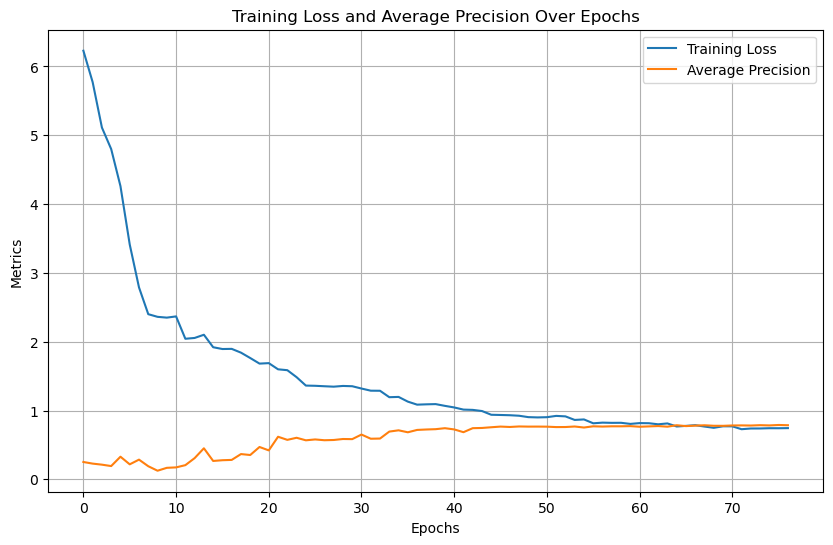

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(epoch_losses, label='Training Loss')
plt.plot(epoch_precisions, label='Average Precision')
plt.xlabel('Epochs')

plt.ylabel('Metrics')
plt.title('Training Loss and Average Precision Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [1]:
correct = 0
total = 0
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct_pred[classes[label.item()]] += 1
            total_pred[classes[label.item()]] += 1
            
print('Accuracy of the network on the 10 000 test images: %f %%' % (100 * correct / total))

for classname, correct_count in correct_pred.items():
    accuracy = 100* float(correct_count)/ total_pred[classname]
    print(f'Accuracy for: {classname:5s} is {accuracy:0.1f} %')

NameError: name 'classes' is not defined

Precision: 0.7860
Recall: 0.7827
F1 Score: 0.7823


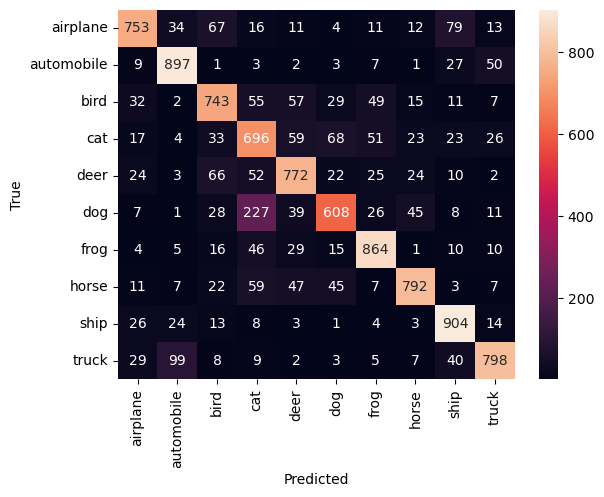

In [34]:
all_labels = []
all_predictions = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predicted.cpu().numpy())

# Concatenate all batches
all_labels = np.concatenate(all_labels)
all_predictions = np.concatenate(all_predictions)

#Assigning classes
def indices_to_class_names(indices, class_names):
    return [class_names[i] for i in indices]

# Apply the mapping to all labels and predictions
all_labels_names = indices_to_class_names(all_labels, classes)
all_predictions_names = indices_to_class_names(all_predictions, classes)

# Calculate metrics using the numerical indices
precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')
f1 = f1_score(all_labels, all_predictions, average='macro')

# Print metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Confusion Matrix with Class Names
conf_matrix = confusion_matrix(all_labels_names, all_predictions_names)
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()